# LeNet-5

This notebook is for the blog: [LeNet-5: The Origin of CNNs](https://derekzhouai.github.io/posts/building-lenet5-for-mnist/)

## Model Implementation

In [ ]:
import torch.nn as nn

class LeNet5(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            # Layer #1
            nn.Conv2d(1, 6, kernel_size=5, stride=1),      # 1x32x32 → 6x28x28
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),         # 6x28x28 → 6x14x14

            # Layer #2
            nn.Conv2d(6, 16, kernel_size=5, stride=1),     # 6x14x14 → 16x10x10
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),         # 16x10x10 → 16x5x5

            nn.Flatten(),                                  # 16x5x5 → 400

            # Layer #3
            nn.Linear(400, 120),                           # 400 → 120
            nn.ReLU(),

            # Layer #4
            nn.Linear(120, 84),                            # 120 → 84
            nn.ReLU(),

            # Layer #5
            nn.Linear(84, num_classes)                     # 84 → 10
        )

    def forward(self, x):
        return self.net(x)

## Model Training

### Preparing the Data

In [2]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

def get_data_loaders(batch_size=128):
    transform = transforms.Compose([
        transforms.Pad(2),  # 28x28 → 32x32
        transforms.ToTensor()
    ])

    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

In [3]:
train_loader, test_loader = get_data_loaders(batch_size=128)
print(f"Number of training samples: {len(train_loader.dataset)}")
print(f"Number of test samples: {len(test_loader.dataset)}")

Number of training samples: 60000
Number of test samples: 10000


In [4]:
X, y = next(iter(train_loader))
print(f"X.shape: {X.shape}")
print(f"y.shape: {y.shape}")

X.shape: torch.Size([128, 1, 32, 32])
y.shape: torch.Size([128])


### Training the Model

In [5]:
import torch

def evaluate(model, loader, loss, device):
    model.eval()
    total_loss, total_correct, total_num = 0.0, 0, 0

    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            
            y_hat = model(X)
            l = loss(y_hat, y)

            total_loss += l.item() * X.size(0)
            total_correct += (y_hat.argmax(dim=1) == y).sum().item()
            total_num += X.size(0)
            
    return total_loss / total_num, total_correct / total_num

In [6]:
def train(model, num_epochs, batch_size, lr, device):
    model.to(device)
    
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()

    train_loader, test_loader = get_data_loaders(batch_size)

    for epoch in range(num_epochs):
        model.train()
        total_loss, total_correct, total_num = 0.0, 0, 0

        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
        
            optimizer.zero_grad()
            y_hat = model(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()

            total_loss += l.item() * X.size(0)
            total_correct += (y_hat.argmax(dim=1) == y).sum().item()
            total_num += X.size(0)

        train_loss = total_loss / total_num
        train_acc = total_correct / total_num

        test_loss, test_acc = evaluate(model, test_loader, loss, device)
        print(f"Epoch {epoch+1}/{num_epochs}: "
              f"Train => Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
              f"Test => Loss: {test_loss:.4f}, Acc: {test_acc:.4f}")

In [7]:
device = (
    torch.device("cuda") if torch.cuda.is_available()
    else torch.device("mps") if torch.backends.mps.is_available()
    else torch.device("cpu")
)
model = LeNet5()
num_epochs = 10
batch_size = 128
lr = 0.5

train(model, num_epochs, batch_size, lr, device)

Epoch 1/10: Train => Loss: 0.7574, Acc: 0.7415 | Test => Loss: 0.1063, Acc: 0.9684
Epoch 2/10: Train => Loss: 0.0903, Acc: 0.9726 | Test => Loss: 0.0640, Acc: 0.9799
Epoch 3/10: Train => Loss: 0.0614, Acc: 0.9808 | Test => Loss: 0.0501, Acc: 0.9838
Epoch 4/10: Train => Loss: 0.0472, Acc: 0.9855 | Test => Loss: 0.0437, Acc: 0.9868
Epoch 5/10: Train => Loss: 0.0398, Acc: 0.9872 | Test => Loss: 0.0538, Acc: 0.9824
Epoch 6/10: Train => Loss: 0.0340, Acc: 0.9891 | Test => Loss: 0.0384, Acc: 0.9884
Epoch 7/10: Train => Loss: 0.0294, Acc: 0.9909 | Test => Loss: 0.0386, Acc: 0.9886
Epoch 8/10: Train => Loss: 0.0252, Acc: 0.9920 | Test => Loss: 0.0333, Acc: 0.9898
Epoch 9/10: Train => Loss: 0.0225, Acc: 0.9929 | Test => Loss: 0.0588, Acc: 0.9818
Epoch 10/10: Train => Loss: 0.0194, Acc: 0.9935 | Test => Loss: 0.0347, Acc: 0.9901


## Model Testing

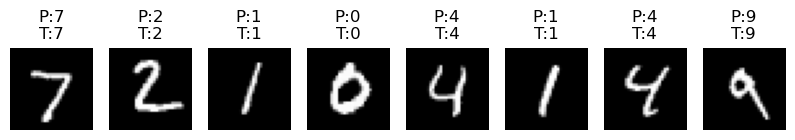

In [8]:
import matplotlib.pyplot as plt

X, y = next(iter(test_loader))
X, y = X[:8], y[:8]
pred = model(X.to(device)).argmax(1).cpu()

plt.figure(figsize=(10,2))
for i in range(8):
    plt.subplot(1,8,i+1)
    plt.imshow(X[i].squeeze(), cmap="gray")
    plt.title(f"P:{pred[i].item()}\nT:{y[i].item()}")
    plt.axis("off")
plt.show()